# Imports

In [1]:
# To install Qiskit, uncomment and run the line below
# !pip install -r requirements.txt --quiet

# If you haven't used your IBMQ account yet, load it using your TOKEN:
# IBMQ.save_account(TOKEN)

# Qiskit imports
import qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
import qiskit.tools.jupyter

# Load provider

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

# Backends

List available backends (quantum computers and simulators) 

In [3]:
for backend in provider.backends():
    print(backend)

ibmq_qasm_simulator
ibmq_armonk
ibmq_santiago
ibmq_bogota
ibmq_lima
ibmq_belem
ibmq_quito
simulator_statevector
simulator_mps
simulator_extended_stabilizer
simulator_stabilizer
ibmq_manila


Get some useful information about each backend

In [4]:
l = ['name', 'max_jobs', 'max_experiments', 'max_shots', 'num_qubits']
print(f'{l[0]: <29} {l[1]: >8} {l[2]: >2} {l[3]: >3} {l[4]: >3}')

for b in provider.backends():
    c = b.configuration()
    print(f'{c.backend_name: <29} {b.job_limit().maximum_jobs: >8} {c.max_experiments: >15} {c.max_shots: >9} {c.num_qubits: >10}')

name                          max_jobs max_experiments max_shots num_qubits
ibmq_qasm_simulator                  5             300     20000         32
ibmq_armonk                          5             100     20000          1
ibmq_santiago                        5             100     20000          5
ibmq_bogota                          5             100     20000          5
ibmq_lima                            5             100     20000          5
ibmq_belem                           5             100     20000          5
ibmq_quito                           5             100     20000          5
simulator_statevector                5             300     20000         32
simulator_mps                        5             300     20000        100
simulator_extended_stabilizer        5             300     20000         63
simulator_stabilizer                 5             300     20000       5000
ibmq_manila                          5             100     20000          5


Instanciate a few backends

In [5]:
backend_sim = Aer.get_backend('qasm_simulator')
backend_qc = provider.get_backend('ibmq_manila')
backend_qc_sim = QasmSimulator.from_backend(backend_qc)

# Create a circuit and run it

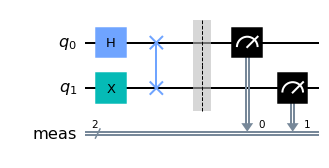

In [6]:
qc = QuantumCircuit(2)
qc.h(0)
qc.x(1)
qc.swap(0, 1)
qc.measure_all()
qc.draw()

Let's run this circuit on ibm `ibmq_qasm_simulator`

In [7]:
job = execute(qc, backend=backend_sim, shots=8192)
print(job.result().get_counts())

{'01': 4118, '11': 4074}


Now let's run it on an actual quantum computer, `ibmq_manila`

In [45]:
job = execute(qc, backend=backend_qc, shots=20000)
print(f'job id is {job.job_id()}')

job id is 61c9edec3b5b8475101034f3


Check the job's status

In [14]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

Check the job's place in the queue

In [9]:
job_monitor(job)

As the notebook becomes unusable if we call certain job functions that halt if the job hasn't run yet, such as `job_monitor(job)` and `job.result()`, it may be more useful to not run them, check the job status with `job.status()`, and later retrieve the job using its id `job.job_id()`:

In [44]:
# job = backend_qc.retrieve_job('61c9edec3b5b8475101034f3')

Get results

In [46]:
print(job.result().get_counts())

{'00': 486, '01': 8572, '10': 494, '11': 10448}


# Bit ordering

The counts results we get using `job.result().get_counts()` use the least significant bit (LSB) convention, meaning that the bottom-most qubit comes first in the bit string. Let's simulate a circuit that illustrates this ordering. 

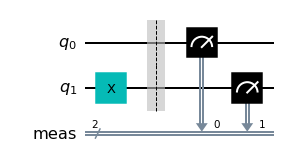

In [12]:
qc = QuantumCircuit(2)
qc.x(1)
qc.measure_all()
qc.draw()

In [13]:
job = execute(qc, backend=backend_sim)
print(job.result().get_counts())

{'10': 1024}


As we can see in the above result, the bottom-most qubit, $q_{1}$, comes first in the result string '10'.

This also needs to be taken into account when using the `initialize` function. To demonstrate this, let's initialize the state |01>, i.e. $q_{0} = 0$ and $q_{1} = 1$, using this function.

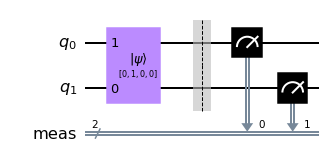

In [39]:
qc = QuantumCircuit(2)

# we want the state |01>, which is the number 1 in binary
state = [0, 1, 0, 0]

# we need to reverse the order of the bits to be initialized
qc.initialize(state, [1, 0])
qc.measure_all()
qc.draw()

In [40]:
job = execute(qc, backend=backend_sim)
print(job.result().get_counts())

{'10': 1024}


We see that in order to get the expected result, in the LSB convention, we needed to reverse the order of the bits to be initialized using `[1, 0]` as argument of `initialize`.

In [11]:
%qiskit_version_table